<a href="https://colab.research.google.com/github/SnapCal/SnapCal-ML/blob/main/modelKeras_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown -q

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pathlib
import zipfile
import numpy as np
import matplotlib.pylab as plt

In [ ]:
print(tf. __version__)

2.15.0


In [ ]:
# dataset = https://drive.google.com/file/d/1BSwXrBStRBy8E-WX0dAVyX_Pf2U5lGi3/view?usp=drive_link
local_zip = '/content/drive/MyDrive/dataset (1).zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
dataset_dir = "/content/dataset"
train_dir = "/content/dataset/train"
valid_dir = "/content/dataset/validation"

In [ ]:
handle_base, pixels, FV_SIZE = ("mobilenet_v2", 224, 1280)
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


# ImageGenerator

In [ ]:
BATCH_SIZE = 64

In [ ]:
# Datagen
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

valid_datagen =  ImageDataGenerator(rescale=1./255)

# Flow training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

# Flow validation data generator
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 2132 images belonging to 20 classes.
Found 600 images belonging to 20 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names = [name.replace('-', ' ') for name in class_names]

# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,),
    output_shape=[FV_SIZE],
    trainable=False
)

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 2283604 (8.71 MB)
Trainable params: 25620 (100.08 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model using MobileNet v2

In [ ]:
from keras import callbacks

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=3,
    restore_best_weights=True
)

In [ ]:
EPOCHS = 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/15
34/34 [==============================] - 163s 5s/step - loss: 2.3305 - accuracy: 0.3072 - val_loss: 1.6288 - val_accuracy: 0.5350
Epoch 2/15
34/34 [==============================] - 151s 4s/step - loss: 1.2632 - accuracy: 0.6693 - val_loss: 1.1229 - val_accuracy: 0.6883
Epoch 3/15
34/34 [==============================] - 158s 5s/step - loss: 0.9181 - accuracy: 0.7645 - val_loss: 0.9177 - val_accuracy: 0.7550
Epoch 4/15
34/34 [==============================] - 143s 4s/step - loss: 0.7615 - accuracy: 0.8021 - val_loss: 0.8556 - val_accuracy: 0.7567
Epoch 5/15
34/34 [==============================] - 151s 4s/step - loss: 0.6393 - accuracy: 0.8368 - val_loss: 0.7854 - val_accuracy: 0.7700
Epoch 6/15
34/34 [==============================] - 162s 5s/step - loss: 0.5539 - accuracy: 0.8630 - val_loss: 0.7184 - val_accuracy: 0.7933
Epoch 7/15
34/34 [==============================] - 144s 4s/step - loss: 0.5105 - accuracy: 0.8766 - val_loss: 0.7023 - val_accuracy: 0.8067
Epoch 8/15
34

# Result

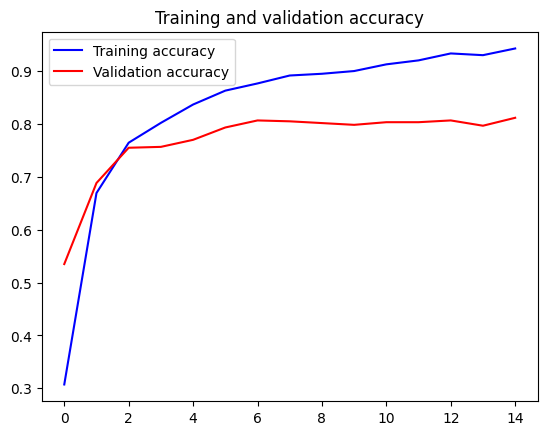

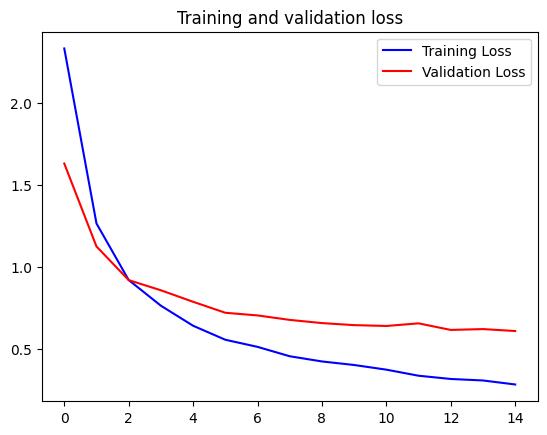

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate final score on Validation
scores = model.evaluate(validation_generator)

10/10 [==============================] - 25s 2s/step - loss: 0.6071 - accuracy: 0.8117


# Export

In [ ]:
model.save('model.h5')
model.save('model')
!zip -r 'model.zip' 'model'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/saved_model.pb (deflated 91%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 78%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model/fingerprint.pb (stored 0%)
  adding: model/keras_metadata.pb (deflated 81%)


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('model')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Invoke the converter to generate the TFLite model
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2532864

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))

10/10 [==============================] - 32s 3s/step
Classification Report
                       precision    recall  f1-score   support

           ayam bakar       0.96      0.77      0.85        30
          ayam goreng       0.78      0.93      0.85        30
                bakso       0.87      0.87      0.87        30
           bubur ayam       0.71      0.17      0.27        30
                 gado       0.64      0.90      0.75        30
        gulai kambing       0.85      0.77      0.81        30
          lele goreng       0.85      0.93      0.89        30
          nasi goreng       0.83      0.80      0.81        30
           nasi putih       0.97      0.97      0.97        30
                rawon       0.76      0.87      0.81        30
              rendang       0.84      0.70      0.76        30
sambal goreng kentang       0.85      0.93      0.89        30
                 sate       0.96      0.87      0.91        30
               seblak       0.78      0.70

Saving WhatsApp Image 2024-06-20 at 11.27.00_ca3ba53c.jpg to WhatsApp Image 2024-06-20 at 11.27.00_ca3ba53c.jpg


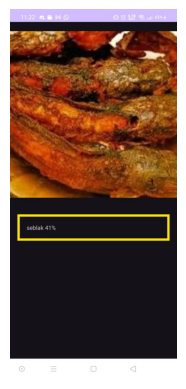

    id      makanan  kalori
6  F07  lele-goreng     105


In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

uploaded = files.upload()

class_names = ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10',
               'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20']

# Membaca data makanan dari file CSV
data_kalori = pd.read_csv("/content/data_kalori.csv")

# Memuat model TFLite
interpreter = tf.lite.Interpreter(model_path="/content/model_metadata.tflite")
interpreter.allocate_tensors()

# Mendapatkan informasi input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for fn in uploaded.keys():
    # Menampilkan gambar
    path = '/content/' + fn
    img = load_img(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Menyiapkan gambar untuk prediksi
    img = load_img(path, target_size=(224, 224))  # Ubah ukuran gambar menjadi 224x224
    x = img_to_array(img)
    x = x.astype('float32')
    x /= 255
    x = np.expand_dims(x, axis=0)

    # Menyiapkan tensor input untuk model TFLite
    interpreter.set_tensor(input_details[0]['index'], x)

    # Melakukan inferensi
    interpreter.invoke()

    # Mendapatkan hasil prediksi
    output_data = interpreter.get_tensor(output_details[0]['index'])

    predicted_class_index = np.argmax(output_data[0])
    predicted_class = class_names[predicted_class_index]

    # Mengambil ID makanan dari nama kelas
    food_id = predicted_class

    # Menampilkan data kalori makanan
    calories_data = data_kalori[data_kalori['id'] == food_id]
    print(calories_data)